# Implementasi Naive Bayes pada Data iris

Naïve Bayes adalah sebuah algoritma klasifikasi yang berbasis pada Teorema Bayes dengan asumsi bahwa setiap fitur dalam data bersifat independen (naïve atau “naif”). Algoritma ini sering digunakan dalam berbagai aplikasi seperti klasifikasi teks, analisis sentimen dan deteksi spam.

## cara hitung

Hitung Kemungkinan dalam Spam

-Kata “Gratis” muncul 6 kali dalam 10 email spam → Peluangnya 6/10 = 60%

-Kata “Hadiah” muncul 5 kali dalam 10 email spam → Peluangnya 5/10 = 50%

-Estimasi probabilitas email ini Spam:

-Ambil nilai tengah → Rata-rata (60% + 50%) ÷ 2 = 55% kemungkinan Spam

Hitung Kemungkinan dalam Bukan Spam

-Kata “Gratis” muncul 2 kali dalam 10 email bukan spam → Peluangnya 2/10 = 20%

-Kata “Hadiah” muncul 1 kali dalam 10 email bukan spam → Peluangnya 1/10 = 10%

-Estimasi probabilitas email ini Bukan Spam:

-Ambil nilai tengah → Rata-rata (20% + 10%) ÷ 2 = 15% kemungkinan Bukan Spam

In [ ]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split

# Fungsi untuk mengambil data dari PostgreSQL
def get_pg_data():
    conn = psycopg2.connect(
        host="pg-3fbafb7b-hrmen55-bd28.i.aivencloud.com",
        user="avnadmin",
        password="AVNS_sc56Zt79uy033vzjIS4",
        database="defaultdb",
        port=23283
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_postgresql")
    data = cursor.fetchall()

    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Fungsi untuk mengambil data dari MySQL
def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-16cb25be-hrmen55-bd28.i.aivencloud.com",
        user="avnadmin",
        password="AVNS_MfLHp-bDUZ-2mkcA1a6",
        database="defaultdb",
        port=23283
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'class'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
X = df_merged[feature_columns].values  # Data fitur
y = df_merged["class"]  # Label klasifikasi

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Menghapus data yang terdeteksi sebagai outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Bagi data menjadi Training (80%) dan Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned[feature_columns], df_cleaned["class"], test_size=0.2, random_state=42
)

# Menampilkan jumlah data setelah pembagian
print(f"Jumlah data setelah pembersihan: {df_cleaned.shape[0]}")
print(f"Training set: {X_train.shape[0]} sampel")
print(f"Testing set: {X_test.shape[0]} sampel")

# Visualisasi data setelah pembersihan
# sns.pairplot(df_cleaned, hue="class")
# plt.show()

Number of mislabeled points with outliers out of a total 30 points : 4
Accuracy with outliers: 86.67%
Mislabeled points with outliers:
Index: 3, True Label: Iris-versicolor, Predicted: Iris-virginica
Index: 4, True Label: Iris-versicolor, Predicted: Iris-virginica
Index: 15, True Label: Iris-versicolor, Predicted: Iris-virginica
Index: 27, True Label: Iris-virginica, Predicted: Iris-setosa

Number of mislabeled points without outliers out of a total 27 points : 0
Accuracy without outliers: 100.00%
Mislabeled points without outliers:


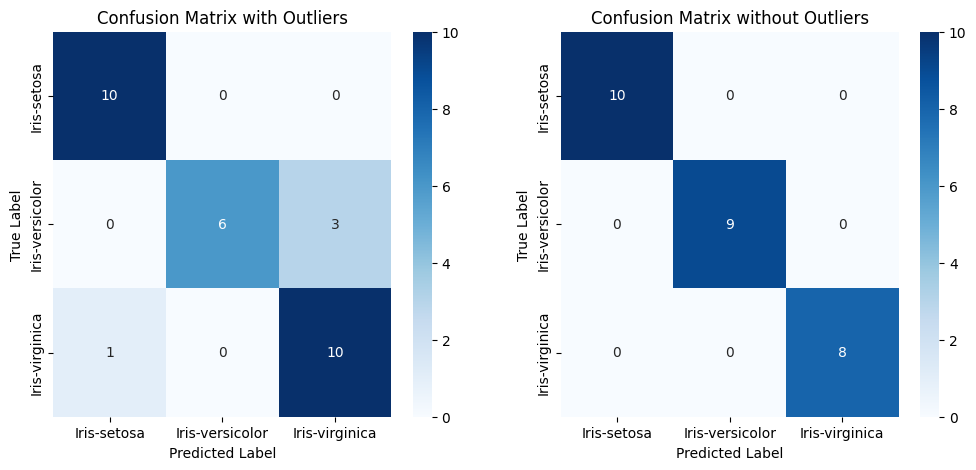

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumsikan df_merged sudah ada dari kode sebelumnya

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
df_merged["class_encoded"] = label_encoder.fit_transform(df_merged["class"])

# Data dengan outlier
X_all = df_merged[feature_columns]
y_all = df_merged["class_encoded"].values  # Pastikan dalam bentuk array numpy

# Data tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])
X_clean = df_cleaned[feature_columns]
y_clean = df_cleaned["class_encoded"].values  # Pastikan dalam bentuk array numpy

# Split data dengan outlier
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42)

# Split data tanpa outlier
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42)

# Inisialisasi model Naive Bayes
gnb = GaussianNB()

# Latih dan uji model dengan outlier
y_pred_all = gnb.fit(X_train_all, y_train_all).predict(X_test_all)
mislabeled_all = (y_test_all != y_pred_all).sum()
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Number of mislabeled points with outliers out of a total %d points : %d" % (X_test_all.shape[0], mislabeled_all))
print("Accuracy with outliers: %.2f%%" % (accuracy_all * 100))

# Menampilkan label yang salah pada data dengan outlier
mislabeled_indices_all = np.where(y_test_all != y_pred_all)[0]
print("Mislabeled points with outliers:")
for i in mislabeled_indices_all:
    true_label = label_encoder.inverse_transform([int(y_test_all[i])])[0]
    predicted_label = label_encoder.inverse_transform([int(y_pred_all[i])])[0]
    print(f"Index: {i}, True Label: {true_label}, Predicted: {predicted_label}")
print()
# Latih dan uji model tanpa outlier
y_pred_clean = gnb.fit(X_train_clean, y_train_clean).predict(X_test_clean)
mislabeled_clean = (y_test_clean != y_pred_clean).sum()
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Number of mislabeled points without outliers out of a total %d points : %d" % (X_test_clean.shape[0], mislabeled_clean))
print("Accuracy without outliers: %.2f%%" % (accuracy_clean * 100))

# Menampilkan label yang salah pada data tanpa outlier
mislabeled_indices_clean = np.where(y_test_clean != y_pred_clean)[0]
print("Mislabeled points without outliers:")
for i in mislabeled_indices_clean:
    true_label = label_encoder.inverse_transform([int(y_test_clean[i])])[0]
    predicted_label = label_encoder.inverse_transform([int(y_pred_clean[i])])[0]
    print(f"Index: {i}, True Label: {true_label}, Predicted: {predicted_label}")

# Visualisasi Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test_all, y_pred_all), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix with Outliers")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(confusion_matrix(y_test_clean, y_pred_clean), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix without Outliers")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()

Kode di atas bertujuan untuk membandingkan performa model Naïve Bayes pada data dengan dan tanpa outlier.

1.Pemrosesan Data -Label Encoding: Label kelas dikonversi ke bentuk numerik menggunakan LabelEncoder agar bisa digunakan dalam model.

-Pemilihan Fitur: Variabel fitur diambil dari feature_columns, sedangkan label target adalah “class_encoded”.

-Penanganan Outlier:

-Dataset dengan outlier: Menggunakan seluruh data (df_merged).

-Dataset tanpa outlier: Menyaring hanya data yang bukan outlier (df_cleaned), dengan mempertahankan hanya data di mana “outlier” == 1.

2.Pembagian Data Data dengan outlier dibagi menjadi training dan testing set menggunakan train_test_split (80% train, 20% test).

Data tanpa outlier juga dibagi dengan cara yang sama.

3.Training & Prediksi dengan Gaussian Naïve Bayes Model GaussianNB dilatih pada kedua dataset:

Model pertama dilatih dengan data yang mengandung outlier.

Model kedua dilatih dengan data yang sudah dibersihkan dari outlier.

Model kemudian memprediksi hasil pada data uji.

4.Evaluasi Model Menghitung jumlah kesalahan prediksi (mislabeled points) pada kedua dataset.

Akurasi dihitung menggunakan accuracy_score:

Akurasi dengan outlier.

Akurasi tanpa outlier.

Menampilkan label yang salah diprediksi untuk melihat di mana model mengalami kesalahan.

5.Visualisasi dengan Confusion Matrix Dua confusion matrix dibuat menggunakan seaborn.heatmap() untuk:

Model dengan outlier.

Model tanpa outlier.

Confusion matrix membantu melihat bagaimana kesalahan prediksi terjadi antar kelas.